# <center>Final Project; Algorithms in Modern Statistics </center>
**Submitted by**: 
**<center>Full Names: Matan Mizrachi, Eyal Stolov</center>**

The following project is fully based on the data, that could be found and explained [here](https://www.kaggle.com/kwadwoofosu/predict-test-scores-of-students).

You might also need to run the following...

In [ ]:
!pip install plotly-express
!pip install tqdm

In [4]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
tqdm.pandas()

**Some Useful Functions**:

In [64]:
def plot_decomposition(est, data: pd.DataFrame, color, dim=2, method='px', hover_data=None, 
                       exclude_dtypes=None, 
                       drop_columns=None, title=''):
    _df = data.copy()
    if drop_columns:
        _df = _df.drop(columns=drop_columns)
    if exclude_dtypes:
        _df = _df.select_dtypes(exclude=exclude_dtypes)
    _df.loc[:, _df.dtypes == object] = _df.loc[:, _df.dtypes == object].progress_apply(lambda _z: _z.astype('category').cat.codes)
    color = _df[color].copy() if method == 'plt' else data[color].copy()
    _df = _df.drop(columns = [color.name]) if color.name in _df.columns else _df
    _x = est.fit_transform(_df)
    _x = pd.DataFrame(_x[:, :dim], columns=[f'dim_{i}' for i in range(1, dim+1)])
    if hover_data:
        if type(hover_data) == str:
            hover_data = [hover_data]
        _x[hover_data] = data[hover_data]
    
    _x[color.name] = color
    
    if dim == 2:      
        if method == 'px':
            fig = px.scatter(_x, x='dim_1', y='dim_2', color=color.name, hover_data=hover_data)
        elif method == 'plt':
            cax = plt.scatter(_x['dim_1'], _x['dim_2'], c=color)
            plt.xlabel('dim_1')
            plt.ylabel('dim_2')

    elif dim == 3:
        if method == 'px':
            fig = px.scatter_3d(_x, x='dim_1', y='dim_2', z='dim_3', color=color.name, hover_data=hover_data)
        elif method == 'plt':
            ax = plt.axes(projection='3d')
            cax = ax.scatter(_x['dim_1'], _x['dim_2'], _x['dim_3'], c=color, marker='o')
            ax.set_xlabel('dim_1')
            ax.set_ylabel('dim_2')
            ax.set_zlabel('dim_3')
    if method == 'px':
        fig.update_layout(
            title={
                'text': title,
                'x': 0.5,
                'y': 0.95,
                'xanchor': 'center',
                'yanchor': 'top'})
        fig.show()
    else:
        plt.title(title)
        plt.colorbar(cax, ticks=np.unique(color))
        plt.show()

In [3]:
df = pd.read_csv('archive/test_scores.csv')
df['lunch'] = df['lunch'].apply(lambda _z: _z if _z == 'Does not qualify' else 'Qualifies')
df.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


## Part 1: EDA

### Visualizing Categorical Data

In [5]:
df.describe(include='object')

,school,school_setting,school_type,classroom,teaching_method,student_id,gender,lunch
count,2133,2133,2133,2133,2133,2133,2133,2133
unique,23,3,2,97,2,2133,2,2
top,GOOBU,Urban,Public,18K,Standard,2FHT3,Male,Does not qualify
freq,158,906,1582,31,1373,1,1077,1215


Based on the tables above, we can basically dismiss the *student_id* feature, as its variety leads to no valuable information to be gained out of it.

In [6]:
df = df.drop(columns=['student_id'])

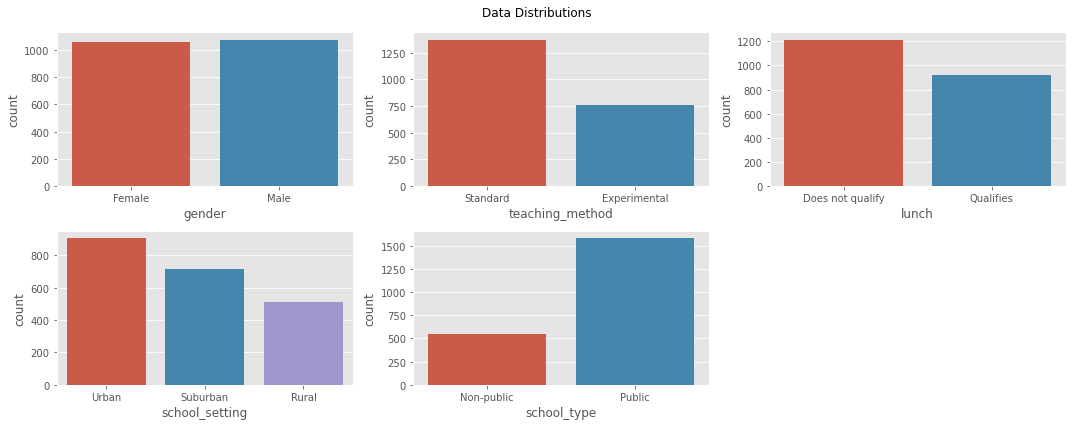

In [5]:
plt.figure(figsize=(15, 6))
plt.suptitle('Data Distributions')
for i, c in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    plt.subplot(2, 3, i+1)
    sns.countplot(df[c])
plt.tight_layout()
plt.show()

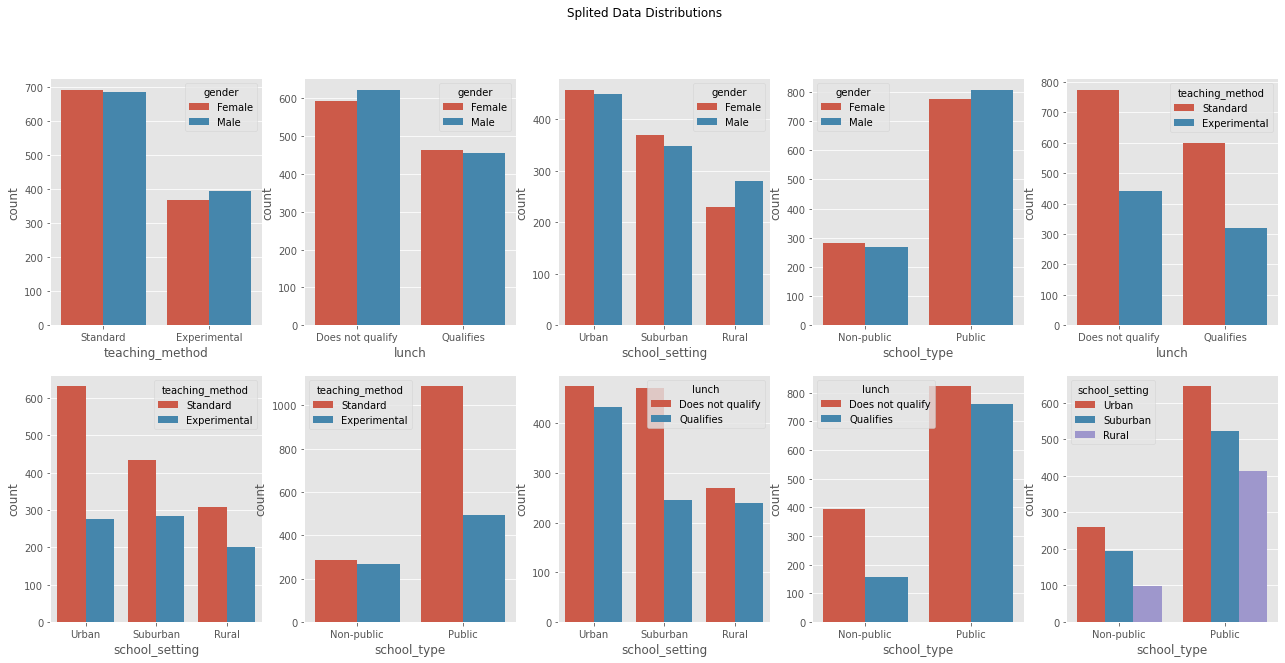

In [6]:
plt.figure(figsize=(22, 10))
plt.suptitle('Splited Data Distributions')
index = 1
for i, hue in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    for j, col in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
        if j <= i:
            continue
        plt.subplot(2, 5, index)
        index += 1
        sns.countplot(data=df, x=col, hue=hue)
plt.show()

We can already see differences in some of the features distributions when dividing them into separated groups;
- School type, divided by teaching method
- School type, divided by *lunch* feature

### Visualizing Numeric Data

In [7]:
df.describe()

,n_student,pretest,posttest
count,2133.000000,2133.000000,2133.000000
mean,22.796531,54.955931,67.102203
std,4.228893,13.563101,13.986789
min,14.000000,22.000000,32.000000
25%,20.000000,44.000000,56.000000
50%,22.000000,56.000000,68.000000
75%,27.000000,65.000000,77.000000
max,31.000000,93.000000,100.000000


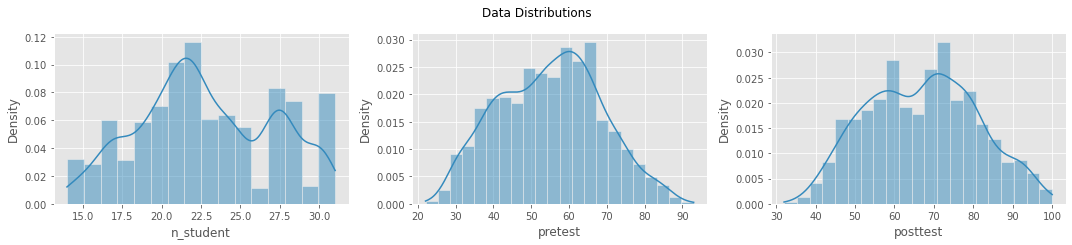

In [8]:
plt.figure(figsize=(15, 6))
plt.suptitle('Data Distributions')
for i, c in enumerate(['n_student', 'pretest', 'posttest']):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df, x=c, kde=True, stat='density', ax=plt.gca())
plt.tight_layout()
plt.show()

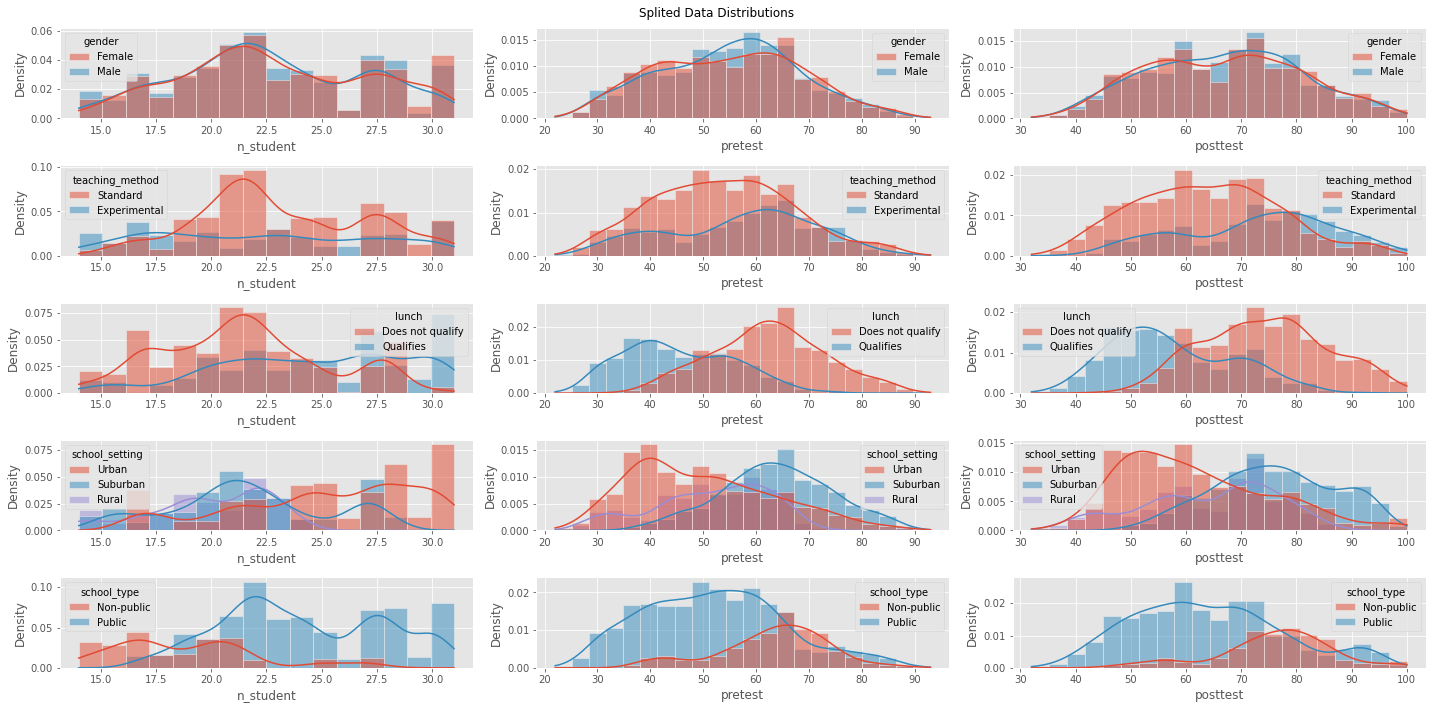

In [11]:
plt.figure(figsize=(20, 10))
plt.suptitle('Splited Data Distributions')
index = 1
for i, hue in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    for j, col in enumerate(['n_student', 'pretest', 'posttest']):
        plt.subplot(5, 3, index)
        index += 1
        sns.histplot(data=df, x=col, hue=hue, kde=True, stat='density', ax=plt.gca())
plt.tight_layout()
plt.show()

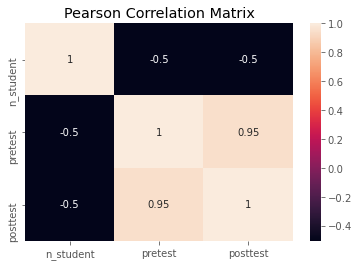

In [12]:
sns.heatmap(df[['n_student', 'pretest', 'posttest']].corr(), annot=True)
plt.title('Pearson Correlation Matrix')
plt.show()

Clearly, the pretest and posttest scores are very highly correlated, almost as if these were the same features to work with.


In [72]:
plot_decomposition(est=PCA(n_components=2, svd_solver='full'), data=df, color='school', 
                   hover_data=['school_type'], exclude_dtypes='object', 
                   title='PCA over Numeric Data', drop_columns=['school', 'classroom'])

0it [00:00, ?it/s]

## Part 2: Hypothesis Testing

Next, we can question whether the differences, of posttest scores, between students that qualifies to free lunch and those that do not, are significant, 